In [26]:
import os
import sys
import shutil
import sqlite3
import xml.etree.ElementTree as ET
import scipy
import scipy.misc
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
% config InlineBackend.figure_format = 'png'

os.chdir('/home/ffw/workspace/plantCLEF/')

## Define functions

In [4]:
DATABASE_PATH = "data/metadata.db"


def run_queries(queries, database_path=DATABASE_PATH):
    conn = sqlite3.connect(database_path)
    c = conn.cursor()
    results = [[r for r in c.execute(q)] for q in queries]    
    conn.commit()
    conn.close()
    return results

def run_query(query):
    return run_queries([query])[0]

# Analyze data and define constraints

### Select content type

In [90]:
constraints = dict()

content_rows = run_query('SELECT Content, count(MediaId), AVG(Vote) FROM images GROUP BY Content')
print "Content types"
print "\n".join(["%10s: %5i %.2f"%r for r in content_rows])

content_type = 'Flower'
constraints['type'] = "Content='%s'" % content_type
constrain = " AND ".join(constraints.values())

print "\nSelected content type: %s" % content_type

Content types
    Branch: 10218 2.39
    Entire: 22348 2.66
    Flower: 36552 3.29
     Fruit:  9143 3.14
      Leaf: 16057 3.12
  LeafScan: 12826 3.62
      Stem:  6060 3.27

Selected content type: Flower


In [87]:

cl, cn = zip(*run_query("SELECT ClassId, count(MediaId) FROM images GROUP BY ClassId"))
id_tble = dict(zip(cl, range(len(cl))))


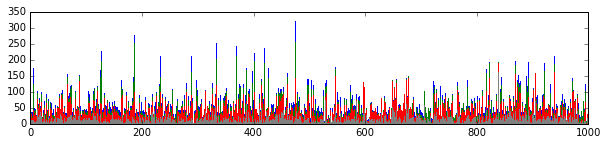

In [91]:
fig = plt.figure(figsize=(10, 2));
previus = {}
for content, color in [('Entire', 'grey'),('Flower', 'r'), ('Leaf', 'g'), ('Branch', 'blue')]:
            
    cl, cn = zip(*run_query(
            "SELECT ClassId, count(MediaId) FROM images WHERE Content = '%s' and not test_set GROUP BY ClassId" % content))
    
    cl = [id_tble[c] for c in cl]
    
    bottom = np.zeros(len(cl))
    for i, c in enumerate(cl):
        if c in previus:
            bottom[i] = previus[c]
            previus[c] += cn[i]
        else:
            previus[c] = cn[i]            
    plt.bar(cl, cn, 1, bottom=bottom, color=color, linewidth=0)
#    plt.plot(cl, cn,'.');
fig.savefig('./figures/dataset_sizes.pdf', bbox_inches='tight')

### Select image sizes

In [47]:
res = run_query("SELECT img_width, img_height, COUNT(MediaID) FROM images WHERE %s GROUP BY img_width, img_height" % constrain)
res = [("%ix%i"%l[:2], l[2]) for l in res]

res.sort(key=lambda x: -x[1])
print "\n".join(["%s: %s" % r for r in res[:6]])

constraints['width'] = "img_width>=350"
constraints['height'] = "img_height>=350"
constrain = " AND ".join(constraints.values())


800x600: 9058
600x800: 4008
800x751: 2603
800x533: 2329
800x800: 2226
800x532: 1371



# Resize images

In [7]:
imgresize_width = 256

output_dir = os.path.join('data', 'images_sq')

hard_redo = False
if hard_redo:
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)    
    run_query("UPDATE images SET imgresize_width = 0, FileNameResize=''")

file_names = run_query("SELECT FileName, MediaID FROM images WHERE %s AND imgresize_width != %i" % (constrain, imgresize_width))

In [8]:
cnt = 0
t0 = time.time()


conn = sqlite3.connect(DATABASE_PATH)
c = conn.cursor() 

for fn, media_id in file_names:
    img = scipy.misc.imread(fn)
    
    basename = os.path.basename(fn)
    output_path = os.path.join(output_dir, basename)
    
    side_len = min(img.shape[:2])
    v_off, h_off = [(s-side_len) // 2 for s in img.shape[:2]]
    if v_off:
        img = img[v_off:-v_off,:]
    if h_off:
        img = img[:, h_off:-h_off]
    img = scipy.misc.imresize(img, size=(imgresize_width,imgresize_width))
    
    scipy.misc.imsave(output_path, img)
    
    q = "UPDATE images SET imgresize_width = %i, FileNameResize='%s' WHERE MediaID = %i"%(imgresize_width, output_path, int(media_id))
    c.execute(q)
    
    cnt += 1
    if not (cnt % 1000):        
        t = time.time() - t0
        print "%6i/%6i: %6i -> %s. (%.1f per sec)" % (cnt,len(file_names), media_id, output_path, cnt / t)
        

conn.commit()
conn.close()

# Visualize cropped and resized images

1988


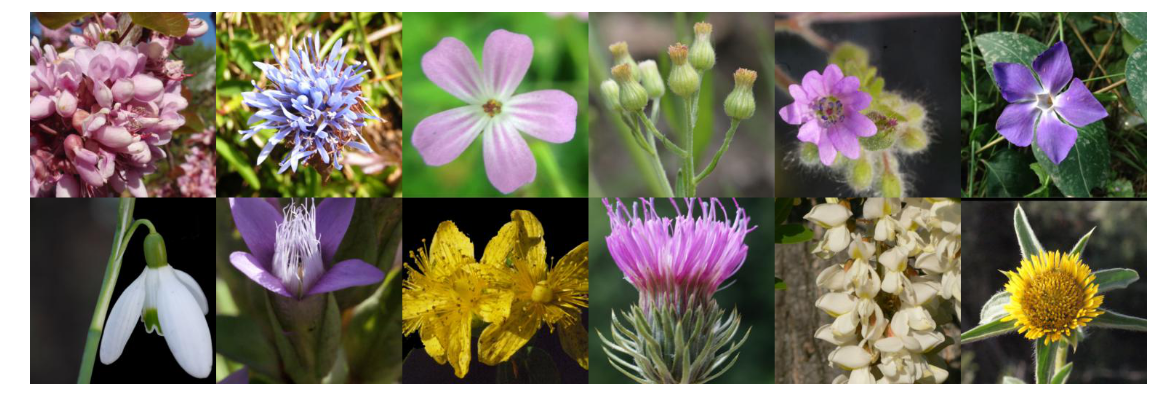

In [40]:


file_names = run_query("SELECT FileNameResize FROM images WHERE %s AND Vote > 4" % constrain)
#file_names = run_query("SELECT FileNameResize FROM images WHERE %s and Species LIKE '%%Orchis simia%%' AND Vote > 3" % constrain)

print len(file_names)
cols = 6
rows = 2

images = None
for _ in range(rows):
    imagerow = None
    for i in np.random.randint(len(file_names), size=cols):
        
        img = scipy.misc.imread(file_names[i][0])        
        if imagerow is None:
            imagerow = img
        else:
            imagerow = np.append(imagerow, img, axis=1)
            
    if images is None:
        images = imagerow
    else:
        images = np.append(images, imagerow, axis=0)
            
    
plt.figure(figsize=(20, 10))
plt.imshow(images)
plt.axis('off');

# Analyze and select classes

There are totally 28195 samples
distributed over 967 classes


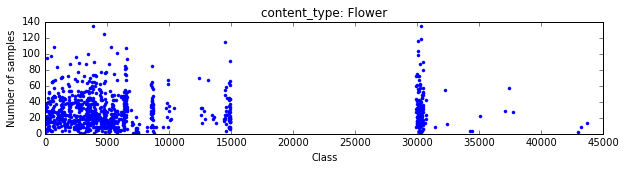

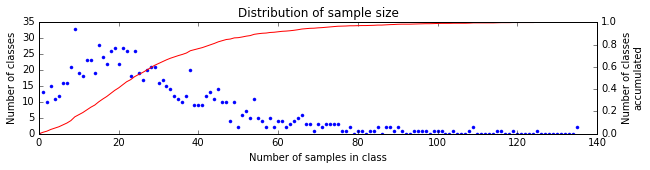

In [39]:
classes =run_query(
        "SELECT ClassId, Species, count(MediaId) FROM images WHERE %s and not test_set GROUP BY ClassId" 
        % constrain)
cl, species, cn = zip(*classes)
species_table = dict(zip(cl, species))

_, ax1 = plt.subplots(figsize=(10, 2))
plt.title("content_type: %s" % content_type);
ax1.plot(cl, cn,'.');
plt.xlabel('Class')
ax1.set_ylabel('Number of samples')

cnt_total = sum(cn)
nclasses = len(cl)

print "There are totally %i samples" % cnt_total
print "distributed over %i classes" % nclasses


hist = {c:0 for c in range(max(cn)+1)}
for c in cn:
    hist[int(c)] += 1

    
fig, ax1 = plt.subplots(figsize=(10, 2))
ax2 = ax1.twinx()    
plt.title("Distribution of sample size");
ax2.plot(hist.keys(), np.cumsum(hist.values()) / float(nclasses),'-r');
ax1.plot(hist.keys(), hist.values(),'.b');
ax1.set_xlabel('Number of samples in class');
ax1.set_ylabel('Number of classes');
ax2.set_ylabel('Number of classes\naccumulated');

fig.savefig('./figures/dataset_size_distr.pdf', bbox_inches='tight')

<a href=../figures/dataset_size_distr.pdf download="dataset_size_distr">Download distribution graph<a/>

### Select subset
I select a subset of classes with a size representative for the distribution. (around 20)

In [12]:
class_subset = [c for i, c in enumerate(cl) if 0 < cn[i]]

constraints['class'] = "classID in (%s)" % (",".join(map(str,class_subset)))
constrain = " AND ".join(constraints.values())

print "Selected %i classes" % (len(class_subset))
print "-----------------------"
print "\n".join([species_table[c] for c in class_subset[:5]])
print "..." if len(class_subset)>5 else ""

Selected 967 classes
-----------------------
Acer pseudoplatanus L.
Acer saccharinum L.
Carpobrotus edulis (L.) N.E.Br.
Amaranthus deflexus L.
Cotinus coggygria Scop.
...


### Create lookup tables for selected classes
The class ids need to be ordered in a sequencital order from 0..len(cl). Therefore, I create a lookup table for converting the ids.

In [18]:
id_tuples = zip(range(len(class_subset)), class_subset)
ss2cl = dict(id_tuples)
cl2ss = dict([(c,s) for (s,c) in id_tuples])

'Number of classes: 967'

# Generate data set lists

In [14]:
# List of species for later lookup
species_list_path = 'data/species.txt'
species_list = "\n".join([species_table[c] for c in class_subset])
open(species_list_path,'w').write(species_list.encode('utf8'))

res_train = run_query("SELECT FileNameResize, ClassID FROM images WHERE %s and not test_set" % constrain)
res_test = run_query("SELECT FileNameResize, ClassID FROM images WHERE %s and test_set" % constrain)


format_list = lambda x: "%s %s" % (os.path.abspath(x[0]), cl2ss[x[1]])
#format_list = lambda x: "%s %s" % (os.path.basename(x[0]), cl2ss[x[1]])
res_train_str = "\n".join(map(format_list, res_train))
res_test_str = "\n".join(map(format_list, res_test))

test_list_path = 'data/test.txt'
train_list_path = 'data/train.txt'

open(test_list_path,'w').write(res_test_str)
open(train_list_path,'w').write(res_train_str)

# Generate LMDB
Using the script `convert_imageset` from Caffe

output_path_train = "data/train_lmdb"
output_path_test = "data/test_lmdb"

if os.path.exists(output_path_train):
    shutil.rmtree(output_path_train)
if os.path.exists(output_path_test):
    shutil.rmtree(output_path_test)

args_test = map(os.path.abspath, [output_dir, test_list_path, output_path_test])
args_train = map(os.path.abspath, [output_dir, train_list_path, output_path_train])
args_test[0] += "/"
args_train[0] += "/"

args_test = ["--resize_height=0","--resize_width=0"] + args_test
args_train = ["--resize_height=0","--resize_width=0"] + args_train

print args_test
!convert_imageset ${" ".join(args_test)}

print args_train
!convert_imageset ${" ".join(args_train)}